## 5. 폐렴아 기다려라!

### 모델 순서도

![](https://github.com/ralphpark/first-repository/blob/master/mainquest04.drawio.png?raw=true)

## Model 성능개선을 위한 학습 History


#### Step1(CNN Model)
Batch size 16 -> 32 변경
결과 : 로스 증가 및 정확도 하락으로 다시 16으로 원복

Loss: 0.6576163172721863,

Accuracy: 0.8060897588729858,

Precision: 0.7695390582084656,

Recall: 0.9846153855323792


#### Step2(CNN Model)
데이터 Augumentation 적용(좌우반전)

결과 : 로스 증가 및 정확도 하락으로 이미지 증강방법 변경

Loss: 1.2396695613861084,

Accuracy: 0.7003205418586731,

Precision: 0.6765217185020447,

Recall: 0.9974358677864075


데이터 Augumentation 적용(이미지 회전, 대비, 밝기, 색조, 채도 변경)

결과 : 비교군과 결과 대동소이 함. 오히려 로스 증가로 적용하지 않음

Loss: 0.5711646676063538,

Accuracy: 0.8381410241127014,

Precision: 0.8054968118667603,

Recall: 0.9769230484962463

#### Step3(RasNet18)
RasNet-18 적용

Loss: 0.7320895791053772,

Accuracy: 0.7516025900840759,

Precision: 0.9211469292640686,

Recall: 0.6589743494987488
    
#### Step4(RasNet18)

데이터 증강(좌우반전)

Loss: 0.8430750966072083,

Accuracy: 0.8237179517745972,

Precision: 0.7991452813148499,

Recall: 0.9589743614196777
    
#### Step5(RasNet18)

Learning Rate 0.0001 적용

Loss: 0.580114483833313,

Accuracy: 0.8461538553237915,

Precision: 0.8075313568115234,

Recall: 0.9897435903549194

### Project 개요
#### 폐렴 구별법

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/11_l7pucvb.png)

폐렴의 구별법은 언뜻 예상외로 간단합니다.
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됩니다.
구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/12_e0QcAmT.png)

정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줍니다.
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타납니다.

위와 같이 폐렴에 걸린 사진들은 특징이 패턴을 이루고 있는 것을 볼 수 있습니다.
이런 패턴을 잘 읽어내는 딥러닝 알고리즘은 충분히 학습 시킬 수 있을 것 같죠?
딥러닝 알고리즘들이 패턴인식 알고리즘의 일종이라고 부르는 것처럼,
이 이미지에서 폐렴의 특징 패턴을 학습해서 찾아내게 시키면 됩니다.

그럼 이제 폐렴인지 아닌지에 대해 진단을 내릴 수 있는 딥러닝 모델을 만들어 봅시다.

#### 1. Set-up

패키지(라이브러리)들을 import

In [244]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense


앞으로 필요한 변수들을 생성

In [270]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10 
# 초기 학습률 설정
initial_learning_rate = 0.0001

print(ROOT_PATH)

/aiffel/aiffel


#### 2. 데이터 가져오기

import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/dir_tree.png)

In [271]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [272]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

In [273]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person774_virus_1403.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1295-0001.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

In [274]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1062
Pneumonia images count in training set: 3123


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [275]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

데이터 Augumentation 적용(좌우반전)

In [276]:
2-1 좌우 반전
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [277]:
# #2-2 회전, 대비, 밝기, 색조, 채도 변경 (미적용)
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     # 이미지 회전
#     image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
#     # 이미지 대비 강도 수정
#     image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
#     # 이미지 밝기 수정
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     # 이미지 색조 변경
#     image = tf.image.random_hue(image, max_delta=0.1)
#     # 이미지 채도 변경
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [278]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [279]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [280]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [281]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [282]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [283]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [284]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 3. 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

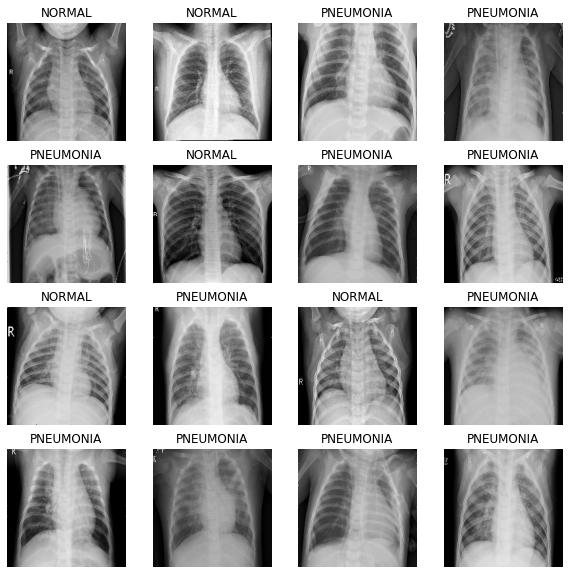

In [285]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### 4. ResNet-18
시작 부분에는 크기가 7x7인 합성곱 필터(Convolutional filter)를 stride 2로 적용합니다.  

그리고나서 3x3 최대 풀링(max pooling)을 stride 2로 진행합니다.  

이후 2개의 Convolutional block을 적용합니다. 이 블록은 각각 2개의 3x3 합성곱 층을 갖습니다. 이 두 블록에서는 채널 수를 64개로 유지합니다.  

그 다음으로는 병합 연산(identical shortcuts)을 도입한 2개의 합성곱목(Convolutional block)이 연속해 나옵니다. 첫 번째 블록에서 채널 수를 128개로 늘립니다.  

같은 과정을 반복해서 채널 수를 256개, 그리고 512개로 늘립니다.

마지막으로는 전역 평균 풀링(Global Average Pooling)을 적용하고, 소프트맥스 함수를 통해 최종 클래스 예측을 Output으로 출력합니다.


In [289]:

# Resnet-18 추가
def conv_block(x, filters, kernel_size, strides=1):
    x_shortcut = x

    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Identity(skip) connection
    if strides != 1:
        x_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=128, kernel_size=3, strides=2)
    x = conv_block(x, filters=128, kernel_size=3)
    x = conv_block(x, filters=256, kernel_size=3, strides=2)
    x = conv_block(x, filters=256, kernel_size=3)
    x = conv_block(x, filters=512, kernel_size=3, strides=2)
    x = conv_block(x, filters=512, kernel_size=3)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


#### 5. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.

In [290]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.97
Weight for PNEUMONIA: 0.67


#### 6. 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [291]:
IMAGE_SIZE = 180
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.

In [292]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 64s 210ms/step - loss: 0.1839 - accuracy: 0.9286 - precision: 0.9763 - recall: 0.9268 - val_loss: 2.0255 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 208ms/step - loss: 0.0871 - accuracy: 0.9653 - precision: 0.9898 - recall: 0.9634 - val_loss: 0.9661 - val_accuracy: 0.7356 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 55s 210ms/step - loss: 0.0661 - accuracy: 0.9765 - precision: 0.9938 - recall: 0.9746 - val_loss: 0.0871 - val_accuracy: 0.9587 - val_precision: 0.9747 - val_recall: 0.9683
Epoch 4/10
261/261 [==============================] - 54s 209ms/step - loss: 0.0448 - accuracy: 0.9816 - precision: 0.9935 - recall: 0.9817 - val_loss: 0.2567 - val_accuracy: 0.9250 - val_precision: 0.9985 - val_recall: 0.8980
Epoch 5/10
261/261 [==============================] - 55s 212ms/step - loss: 0.0394 - accura

#### 7. 결과 확인

이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

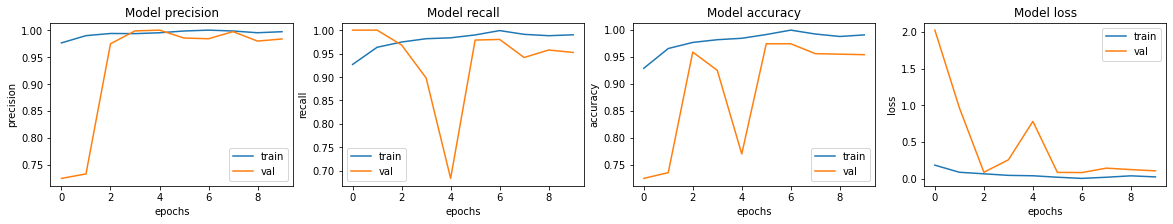

In [293]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [294]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 120ms/step - loss: 0.5801 - accuracy: 0.8462 - precision: 0.8075 - recall: 0.9897
Loss: 0.580114483833313,
Accuracy: 0.8461538553237915,
Precision: 0.8075313568115234,
Recall: 0.9897435903549194
